In [1]:

import numpy as np                       # mathematical methods
from scipy.optimize import leastsq
from scipy import stats                  # contains some fitting routines
from scipy import signal
from scipy.signal import chirp
from scipy.signal import argrelextrema
import pandas as pd

from peakdetection import detect_peaks

#import matplotlib.pylab as plt
from matplotlib import pyplot as plt     # plotting methods within notebook

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


%matplotlib inline


plot = True
#plot = False

def kepler(x, I) : #inputs: resting potential v0,u0 , current[certaintime]
    GNa = 120.0
    GK = 36.0
    GL = 0.3
    ENa = +50.0
    EK = -77.0
    EL = -54.384
    C = 1.0 
    PT = 1.0

    V = x[0] 
    U = x[1]

    z = (U+55.0)/10.0
    ns = 1.0/(1.0+12.5*np.exp(-(U+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # ns = 1.0/(1.0+12.5*np.exp(-(U+65.0)/80.0)*(1.0-np.exp(-(U+55.0)/10.0))/(U+55.0))

    dU = 0.001
    z = (U+dU+55.0)/10.0
    nsU = 1.0/(1.0+12.5*np.exp(-(U+dU+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # nsU = 1.0/(1.0+12.5*np.exp(-(U+dU+65.0)/80.0)*(1.0-np.exp(-(U+dU+55.0)/10.0))/(U+dU+55.0))

    z = (V+55.0)/10.0
    nsV = 1.0/(1.0+12.5*np.exp(-(V+65.0)/80.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # nsV = 1.0/(1.0+12.5*np.exp(-(V+65.0)/80.0)*(1.0-np.exp(-(V+55.0)/10.0))/(V+55.0))

    z = (V+40.0)/10.0
    ms = 1.0/(1.0+40.0*np.exp(-(V+65)/18.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # ms = 1.0/(1.0+40.0*np.exp(-(V+65)/18.0)*(1.0-np.exp(-(V+40.0)/10.0))/(V+40.0))

    dV = 0.001
    z = (V+dV+40.0)/10.0
    msV = 1.0/(1.0+40.0*np.exp(-(V+dV+65)/18.0)*0.1*(1.0 if abs(z) < 1e-4 else (1.0-np.exp(-z))/z))
    # msV = 1.0/(1.0+40.0*np.exp(-(V+dV+65)/18.0)*(1.0-np.exp(-(V+dV+40.0)/10.0))/(V+dV+40.0))

    hs = 1.0/(1.0+1.0/(0.07*np.exp(-(U+65)/20.0)*(np.exp(-(U+35.0)/10.0)+1.0)))
    hsU = 1.0/(1.0+1.0/(0.07*np.exp(-(U+dU+65)/20.0)*(np.exp(-(U+dU+35.0)/10.0)+1.0)))
    hsV = 1.0/(1.0+1.0/(0.07*np.exp(-(V+65)/20.0)*(np.exp(-(V+35.0)/10.0)+1.0)))

    dgNa = GNa*ms*ms*ms*(V-ENa)
    dgK = GK*4.0*ns*ns*ns*(V-EK)
    th = 1.0/(0.07*np.exp(-(V+65.0)/20.0)+1.0/(np.exp(-(V+35.0)/10.0)+1.0))

    z = (V+55.0)/10.0
    tn = 1.0/(0.125*np.exp(-(V+65)/80.0)+0.1*(1.0 if abs(z) < 1e-4 else z/(1.0-np.exp(-z))))
    # tn = 1.0/(0.125*np.exp(-(V+65)/80.0)+0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0)))

    z = (V+40.0)/10.0
    # tm = 1.0/(4.0*np.exp(-(V+65.0)/18.0)+0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0)))
    tm = 1.0/(4.0*np.exp(-(V+65.0)/18.0)+(1.0 if abs(z) < 1e-4 else z/(1.0-np.exp(-z))))

    a = dgNa*(hsV-hs)/th+dgK*(nsV-ns)/tn
    b = dgNa*(hsU-hs)/dU+dgK*(nsU-ns)/dU

    g = GL + GK*ns*ns*ns*ns + GNa*ms*ms*ms*hs
    dFdVm = GNa*3.0*ms*ms*hs*(V-ENa)*(msV-ms)/dV
    alpha = 0.5*(C/tm+g - np.sqrt((C/tm+g)*(C/tm+g)-4.0*(g+dFdVm)*C/tm))/(g+dFdVm)

    GNaGates = GNa*ms*ms*ms*hs
    GKGates = GK*ns*ns*ns*ns

    INa = GNaGates*(V-ENa)
    IK = GKGates*(V-EK)
    IL = GL*(V-EL)

    dVdt = alpha * (-INa-IK-IL+I)/C   
    dUdt = a/b                         

    return dVdt, dUdt               
#returns changes in V and U for a certain v0 and u0 and current[time k]

#HH-style

def trajectory(derivative, tmin, tmax, I0, I1, v0, u0) :
    deltat = 0.01
    time = np.arange(tmin, tmax, deltat)
    # = [tmin, tmin+deltat, tmin+2deltat, ..., tmax - deltat], len(time) = (tmax - tmin) / deltat
    x = np.zeros((2, len(time)))
    # 2-dim Array of len(time)x 0's x2
    current = np.zeros(len(time))
    # 1-dim Array of len(time)x 0's
    current[time<0.0] = I0
    # set current below time = 0 on I0
    current[time>=0.0] = I1
    # set current beginning at time = 0 on I1
    xx = [ v0, u0 ]
    for k in range(len(time)) :
        dVdt, dUdt = derivative(xx, current[k]) #gets changes in V and U for a certain current[time k]
        xx[0] += dVdt*deltat 
        xx[1] += dUdt*deltat #add these changes to the former values v0, u0
        x[0,k] = xx[0] #stores all changes in V ...
        x[1,k] = xx[1] #stores all changes in U untill tmax for every timestep
    return time, current, x #returns timearray, currentarray and updated v,u-array


In [12]:

#AOI of which we need a histogramm: I0 = 5, I1 = 8, f = {x1,x2,x3,...}


def spikeresponse_rec15_hist(derivative, I0, I1, freq) :
    #tmax = 10000.0
    #tmax = 600.0
    tmax = 2000.0
    dt = 0.01
    time = np.arange(int(tmax/dt))*dt #[ 0, dt, 2dt, ... , (tmax / dt) dt = tmax]
    thresh = -20.0
    taus = 1.0 #changed taus as an input
    stime = np.arange(0.0, 1.5 * taus, dt) #spiketime: [0, dt, 2dt, ..., 8taus] WHY 8?

    spulse = (I1-I0) + 0 * stime

    rates = [] #creates empty array
    dp = 1000.0/freq          #period = distance of pulses (= 1000 ms / frequency)
    pulses = np.arange(0.0, tmax-(1.5*taus), dp) #pulses occuring between 0 and tmax-8taus with dist. dp
    current = np.zeros(len(time)) + I0 #current = I0 for all the time
    for pt in pulses: #loop through all the pulse-times
        current[int(pt/dt):int(pt/dt)+len(spulse)] += spulse
            #add spulse (growth) while current is between pt and pt + 8tau/dt (= back at rest. pot)
            # = adds a full spulse on the current to the next pulse (dimensions are perfectly fit)
    t, i, x = trajectory(derivative, -100.0, tmax, I0, current, -65.0, -65.0)
        #...
    spikes = t[:-1][(x[0][:-1]<thresh) & (x[0][1:]>=thresh)]
        #array of times where value just jumps over threshhold
    spikes = spikes[spikes>1200.0] #only pick spikes, which occur for t>100ms
    rate = 0.0
    if len(spikes) > 2: #more han two spikes occur
        rate = 1000.0*(len(spikes)-1)/(spikes[-1]-spikes[0]) #
    rates.append(rate) #put all rate together in rates (evaluate one rate per frequency)
    
    phis = np.zeros(len(spikes))
    phis = ((spikes % dp) / dp) * 2 * np.pi
    phis_x = np.cos(phis)
    phis_y = np.sin(phis)
    
    phis_x_mean = np.mean(phis_x)
    phis_y_mean = np.mean(phis_y)
    
    phi_mean = np.arctan2(phis_y_mean, phis_x_mean)
    vector_strength = np.sqrt(phis_x_mean**2 + phis_y_mean**2)
        
    if phi_mean < 0:
        phi_mean += 2 * np.pi
        
    if rate == 0.0:
        phi_mean = -1
        vector_strength = -1
    
    
    
    #SPIKE DETECTION

    maxima_indices, xyz = detect_peaks(x[0][10000:(10000+int(dp/dt))], .1)
    maxima_times = maxima_indices * dt
    
    
    maxima_values = (x[0][10000+maxima_indices])
    
    #print(maxima_indices)
    #plt.plot(t, i)
    #
    #plt.plot(t, x[0])
    #plt.plot(maxima_times+200, maxima_values, 'o')
    #plt.axis((200,300,-60,40))
    isi = np.diff(maxima_indices)
    rel_isi = (isi / dp) * dt
    
    #print(isi)
    #print(rel_isi)
    
    #bins = np.linspace(np.min(rel_isi), np.max(rel_isi), 20)
    bins = np.linspace(.9, 6, 20)
    
    #plt.figure(figsize=(12,5))
    #plt.hist(rel_isi, bins)#, normed=True)
    #plt.title('k = {:.2f}, f = {}'.format(rate/freq, freq))
    
    #put isi in different bins: min should be one dp (period), max wil be about some periods
    #scott histogramm? $w = \frac {3.49 \cdot \sigma} {\sqrt[3]{n}}$

    #plt.plot(t, x[0])
    #plt.plot(maxima_times, maxima_values, 'o')
    #plt.axis((-1,dp,-66,-55))
    #return rate/freq, vector_strength
    
    
    #return t, x[0], i, rate
    return t, x[0], i
    #return rate/freq#, vector_strength

In [ ]:



plot = True
periodpic = False
#farea = np.round(np.arange(63, 108+.1, .1), 1)63.7, 
farea = np.round(np.arange(81.1, 81.3, .025), 3)
#farea = np.round(np.arange(73.30, 108+.05, .05), 2)
#frequence: 73.35, period: 13.63, whole period: 8.0
#farea = np.round(np.arange(63.7, 63.8, .05), 2)
dt = .01
pf = []

#print(farea)
#farea = (76.0, 98.1)
#farea = np.arange(98, 98.2, .1)
#farea = np.arange(77.7, 83, .1)
#farea = (77.1, 77.2)
#farea = (68, 69, 76, 82, 98, 99)
#farea = [68, 80]

if plot:
    fig = plt.figure(figsize=(30,len(farea)*8))



for f in farea:
    
    t, x, i = spikeresponse_rec15_hist(kepler, 5.0, 8.0, f)
    
    #set x just to x beginning with 100 ms
    x = x[int(300/dt):]
    
    xold = x

    #normalization
    x = x - np.mean(x)
    x = x / np.std(x)
    
    #ac = np.correlate(x[int(100/.01):int(int(100+50*1000.0/93)/.01)], x[int(100/.01):int(int(100+50*1000.0/93)/.01)], 'full')
    #correlate input 20-60 with whole x
    #ac2 = np.correlate(x[int(20*1000.0/f/.01):int(int(40*1000.0/f)/.01)], x, 'same')
    ac2 = np.correlate(x, x[int(0*1000.0/f/dt):int(int(20*1000.0/f)/dt)],'valid') / len(x[int(0*1000.0/f/dt):int(int(20*1000.0/f)/dt)])
    #ac2 = (ac2 - np.mean(ac2)) / np.std(ac2) activate!!!
    #ac2 = np.correlate(x, x, 'same')

    
    #pick a relevant interval
    #ac2int = ac2[int(200/.01):int(int(200+50*1000.0/95)/.01)]
    #ac2int = ac2[int(30*1000.0/f/.01):int(int(60*1000.0/f)/.01)] #what is the right interval?
    
    #alternative:
    #ac2int = ac2[ac2>=0.23]
    ac2int = ac2
    t = t[int(300/dt):]
    tint = t[:-int(int(20*1000.0/f)/dt)+1]
    #tint = tint[ac2>=0.23]
    
    #plt.plot(tint, ac2int)
    
    #ac2int = ac2[int(200/.01):int(600/.01)]
    
    


    #plot autocorrelation
    #plt.plot(t, ac2)
    #plt.axis((0*1000.0/f-100, 50*1000.0/f, 2.5, np.max(ac2)+.1))
    
    
    #detect peaks in ac
    #ac2_maxima, noneed = detect_peaks(ac2int, 1.05)
    ac2_maxima, noneed = detect_peaks(ac2, (np.max(ac2)-np.min(ac2))*.96)
    #ac2_maxima_times, noneed2 = detect_peaks(ac2int, 1.05, time = tint)
    ac2_maxima_times, noneed2 = detect_peaks(ac2, (np.max(ac2)-np.min(ac2))*.96, time = tint)
    
  #  print(tint[0])
  #  print(ac2_maxima_times)
    
    #print(ac2_maxima)
    
    ac2_maxima_times = np.append(tint[0], ac2_maxima_times)
    ac2_maxima = np.append(0, ac2_maxima).tolist()
    ac2_maxima[0] = int(0)
    
   # print(ac2_maxima_times)
    #print(type(ac2_maxima))
    #print(ac2_maxima)
    
    #ac2_maxima_indices = ac2
    if len(ac2_maxima) != 0:
        ac2_maxima_values = ac2[ac2_maxima]
        
    

    #ac2_maxima_times_diff = ac2_maxima_times - (ac2_maxima_times[0] - t[int(0*1000.0/f/.01)+int(300/.01)])
    #ac2_maxima_times_diff = ac2_maxima_times - 100
    #print(ac2_maxima_times)
    #print(ac2_maxima_times_diff)
    #print(ac2_maxima)
    #print(tint[-1])
    if plot:

    #plot autocorrelation in the specific interval
        #plt.plot(t[int(100/.01):int(int(100+50*1000.0/93)/.01)], ac)
        #fig = plt.figure(figsize=(20,16))
        #fig.add_subplot(len(farea)+1, 2, 1+2*(f-farea[0]))
        fig.add_subplot(len(farea)+1, 2, 1+2*np.where(np.asarray(farea) == f)[0][0])
        if f==farea[0]:
            plt.title('Autocorrelation')
        #plt.plot(t[int(200/.01):], ac2)
        plt.plot(tint, ac2int, label = f)
        if len(ac2_maxima) != 0:
            plt.plot(ac2_maxima_times, ac2_maxima_values, 'o')
        #plt.plot(t[:-int(300/.01)], ac2int)
        #plt.plot(t[int(30*1000.0/f/.01):int(int(60*1000.0/f)/.01)], ac2int)
        #plt.plot(t[int(200/.01):int(600/.01)], ac2int)
        if f==farea[len(farea)-1]:
            plt.xlabel('time [ms]')
        plt.legend(loc = 'upper right')
    #ac2_maxima_times = ac2_maxima * .01 + 200
    
    #find periods
    ac2_maxima_times_isi = np.diff(ac2_maxima_times)
    #ac2_maxima_times_isi = np.concatenate(([0], ac2_maxima_times_isi))#notneeded?
    print(ac2_maxima_times_isi)


    #print(ac2_maxima_times)
    
    #print(tint[0])

    periodic = True
    #print(len(tint)*.01 / 2)
    #if ac2_maxima_times_isi[0]
   # if np.sum(ac2_maxima_times_isi) < (len(tint)*.01 / 2):
   #     periodic = False
    
        
    if len(ac2_maxima_times_isi) < 1:
        periodic = False


    
    
    if len(ac2_maxima_times_isi) != 0:
 #       print((len(tint)*.01) // ac2_maxima_times_isi[0])
        print(len(ac2_maxima_times_isi))
        print(((len(tint)*dt) // ac2_maxima_times_isi[0]) -1)
        #if len(ac2_maxima_times_isi) != (((len(tint)*dt) // ac2_maxima_times_isi[0])):
        if ((((len(tint)*dt) // ac2_maxima_times_isi[0]) -1) - len(ac2_maxima_times_isi)) >= 2:
            
            periodic = False
    
    for i in range(0, len(ac2_maxima_times_isi)-1, 1):
            if np.round(ac2_maxima_times_isi[i], -1) != np.round(ac2_maxima_times_isi[i+1], -1):
                periodic = False

    #if len(ac2_maxima_times_isi) == 1:   #should be ISI??
    #    if ac2_maxima_times[0] < len(tint)*dt/2:
    #        period = False
    #    print(ac2_maxima_times)
        
    #if len(ac2_maxima_times) == 1:   #should be ISI??
    #    if ac2_maxima_times[0] < (1000.0-(20*1000.0/f))/2:
    #        period = False
    #    print(ac2_maxima_times)

    if periodic:
        
        ac2_maxima_values = ac2int[ac2_maxima]
        if len(ac2_maxima_times) == 1:
            period = round(((ac2_maxima_times[0] - t[0]) / (1000.0/f)), 1)
        else:
            period = round((ac2_maxima_times_isi[0] / (1000.0/f)), 1)
        
        #if f == 80:
        #    period = round(((ac2_maxima_times[1] - t[0])/ (1000.0/f)), 1)
        #    print((ac2_maxima_times[1] - t[0]))
            
       # if f in (68, 69, 76, 82, 98, 99):
            #period = 0
       #     period = 30
        
        
        #print(f)
        #print((1000.0/f))
        #print(period)
        print('frequence: {}, period: {:.2f}, whole period: {}'.format(f, 1000.0/f, period))
       # print(ac2_maxima_times_isi)
        pf.append(period)
        
        if plot:
            plt.plot(ac2_maxima_times, ac2_maxima_values, 'o')
            #plt.figure(figsize=(10,8))

            fig.add_subplot(len(farea)+1, 2, 2+2*np.where(np.asarray(farea) == f)[0][0])
            if f==farea[0]:
                plt.title('Voltagetrack')
            #plt.plot(t[int(300/.01):], x, label = f)
            plt.plot(t, xold, label = f)
            if f==farea[len(farea)-1]:
                plt.xlabel('time [ms]')
            plt.ylabel('Voltage V(t) [mV]')
            plt.axis((int(0*1000.0/f)+180, 1000, -80, -10))
            #plt.axis((200, 600, -80, -10))
            plt.legend(loc = 'upper right')
            plt.axvline(x=t[int(0*1000.0/farea[len(farea)-1]/dt)], color='blue')
            plt.axvline(x=t[int(20*1000.0/farea[len(farea)-1]/dt)], color='blue')

            for periods in range(0,len(ac2_maxima_times), 1):
            #plt.axvline(x=periods*ac2_maxima_times_isi[periods]+int(30*1000.0/f))
                #plt.axvline(x=ac2_maxima_times_diff[periods], color = 'red') activate
                plt.axvline(x=ac2_maxima_times[periods], color = 'red')
    else:
        print('frequence {}, no period found'.format(f))
        #plt.figure(figsize=(10,8))
        
        period = 30
        pf.append(period)
        if plot:
            fig.add_subplot(len(farea)+1, 2, 2+2*np.where(np.asarray(farea) == f)[0][0])
            if f==farea[0]:
                plt.title('Voltagetrack')
            #plt.plot(t[int(300/.01):], x, label = f)
            plt.plot(t, xold, label = f)
            if f==farea[len(farea)-1]:
                plt.xlabel('time [ms]')
            plt.ylabel('Voltage V(t) [mV]')
            plt.axis((int(0*1000.0/f)+180, 1000, -80, -10))
            plt.axvline(x=t[int(0*1000.0/farea[len(farea)-1]/dt)], color='blue')
            plt.axvline(x=t[int(20*1000.0/farea[len(farea)-1]/dt)], color='blue')
            #plt.axis((200, 600, -80, -10))
            plt.legend(loc = 'upper right')
#plt.figure(figsize=(10,8))
#plt.plot(t[int(200/.01):], x)
#plt.plot(t[int(300/.01)+int(0*1000.0/f/.01):int(300/.01)+int(int(20*1000.0/f)/.01)], x[int(0*1000.0/f/.01):int(int(20*1000.0/f)/.01)])
#plt.axvline(x=x[int(20*1000.0/farea[len(farea)-1]/.01)], color= 'red')
#plt.axvline(x=x[int(40*1000.0/farea[len(farea)-1]/.01)], color='red')
#plt.savefig('spikes{}{}.png'.format(farea[0], farea[-1]))
print(pf)

if periodpic: 
    plt.figure(figsize=(12,8))
    plt.plot(farea, pf);
    plt.xlabel('Input frequency [Hz]', fontsize = 15);
    plt.ylabel('Periodlength in No. of Inputperiods', fontsize = 15);

    #texts
    plt.text(66.20, 1.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
    plt.text(66.20, 2.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
    plt.text(66.20, 3.0, r'$(2)_0 (3)_1$', color = 'red', fontsize = 13)
    plt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)
    plt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)
    plt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)
    plt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)
    plt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)
    plt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)
    plt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)
    plt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)
    plt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)
    plt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)

    #lines and dots
    possibleperiods = np.arange(1.0, 15.0, 1.0)
    possibleperiods = np.delete(possibleperiods, 9)
    for b in possibleperiods:
        plt.hlines(y=b, xmin=63.0, xmax = 66.25, color = 'red')
        #print(b)
        for a in np.where(pf==b)[0]:
            np.where(pf==b)[0]
            #print(a)
            plt.plot(farea[a], b, 'o', color = 'red')

    plt.axis((np.min(farea), np.max(farea), 0, 15))
    #plt.axis((60, 110, 0, 15))
   # plt.grid()

#plt.savefig('Rec_periods_end2')
#plt.savefig('Rec_periods_outlier2')


In [2]:
def spikeresponse_rec15_hist(derivative, I0, I1, freq) :
    tmax = 20000.0
    #tmax = 600.0
    #tmax = 1000.0
    dt = 0.01
    time = np.arange(int(tmax/dt))*dt #[ 0, dt, 2dt, ... , (tmax / dt) dt = tmax]
    thresh = -20.0
    taus = 1.0 #changed taus as an input
    stime = np.arange(0.0, 1.5 * taus, dt) #spiketime: [0, dt, 2dt, ..., 8taus] WHY 8?
    spulse = (I1-I0) + 0 * stime

    rates = [] #creates empty array
    dp = 1000.0/freq          #period = distance of pulses (= 1000 ms / frequency)
    pulses = np.arange(0.0, tmax-(1.5*taus), dp) #pulses occuring between 0 and tmax-8taus with dist. dp
    current = np.zeros(len(time)) + I0 #current = I0 for all the time
    for pt in pulses: #loop through all the pulse-times
        current[int(pt/dt):int(pt/dt)+len(spulse)] += spulse
            #add spulse (growth) while current is between pt and pt + 8tau/dt (= back at rest. pot)
            # = adds a full spulse on the current to the next pulse (dimensions are perfectly fit)
    t, i, x = trajectory(derivative, -100.0, tmax, I0, current, -65.0, -65.0)
        #...
    spikes = t[:-1][(x[0][:-1]<thresh) & (x[0][1:]>=thresh)]
        #array of times where value just jumps over threshhold
    spikes = spikes[spikes>1200.0] #only pick spikes, which occur for t>100ms
    rate = 0.0
    if len(spikes) > 2: #more han two spikes occur
        rate = 1000.0*(len(spikes)-1)/(spikes[-1]-spikes[0]) #
    rates.append(rate) #put all rate together in rates (evaluate one rate per frequency)
    
    
    #SPIKE DETECTION

    maxima_indices, xyz = detect_peaks(x[0][130000:], 20) #changed to 30000 from 20000
    if len(maxima_indices)==0:
        print(m)
    maxima_times = maxima_indices * dt
    print(maxima_indices)
    maxima_values = (x[0][130000+maxima_indices])
    
    #print(maxima_indices)
    #plt.plot(t, i)
    #
    #plt.plot(t, x[0])
    #plt.plot(maxima_times+100, maxima_values, 'o')
    #plt.axis((200,300,-60,40))
    isi = np.diff(maxima_indices)
    rel_isi = (isi / dp) * dt
    
    #print(isi)
    #print(rel_isi)
    

    bins = np.arange(.8, 6, .2) #??? OLD
    #bins = np.arange(.75, 6.5, 1) #??? OLD
    
    
    #plt.figure(figsize=(12,5))
    #plt.hist(rel_isi, bins)#, normed=True)
    #plt.title('k = {:.2f}, f = {}'.format(rate/freq, freq))
    
    
    #put isi in different bins: min should be one dp (period), max wil be about some periods
    #scott histogramm? $w = \frac {3.49 \cdot \sigma} {\sqrt[3]{n}}$
    
    phis = np.zeros(len(spikes))
    phis = ((spikes % dp) / dp) * 2 * np.pi
    phis_x = np.cos(phis)
    phis_y = np.sin(phis)
    
    phis_x_mean = np.mean(phis_x)
    phis_y_mean = np.mean(phis_y)
    
    phi_mean = np.arctan2(phis_y_mean, phis_x_mean)
    vector_strength = np.sqrt(phis_x_mean**2 + phis_y_mean**2)
        
    if phi_mean < 0:
        phi_mean += 2 * np.pi
        
    if rate == 0.0:
        phi_mean = -1
        vector_strength = -1

    return rel_isi, bins, rate, vector_strength



[    996    3677    6358    9039   11720   14401   17082   19763   22444
   25125   27806   30487   33168   35849   38529   41210   43891   46572
   49253   51934   54615   57296   59977   62658   65339   68020   70701
   73382   76063   78744   81425   84106   86787   89468   92149   94830
   97511  100192  102873  105554  108235  110916  113597  116277  118958
  121639  124320  127001  129682  132363  135044  137725  140406  143087
  145768  148449  151130  153811  156492  159173  161854  164535  167216
  169897  172578  175259  177940  180621  183302  185983  188664  191344
  194025  196706  199387  202068  204749  207430  210111  212792  215473
  218154  220835  223516  226197  228878  231559  234240  236921  239602
  242283  244964  247645  250326  253007  255688  258369  261050  263731
  266412  269092  271773  274454  277135  279816  282497  285178  287859
  290540  293221  295902  298583  301264  303945  306626  309307  311988
  314669  317350  320031  322712  325393  328074  3

[    946    4761    7413   10066   12737   16546   19199   21850   24518
   28366   31020   33689   37507   40159   42811   45484   49290   51942
   54594   57261   61173   63900   67682   70340   73056   76840   79494
   82179   85974   88624   91278   93956   97755  100407  103059  105730
  109539  112192  114844  117513  121331  123982  126636  129306  133115
  135767  138420  141087  144914  147565  150220  152903  156699  159350
  162003  164679  168480  171132  173785  176455  180266  182919  185572
  188241  192057  194708  197361  200031  203843  206495  209148  211817
  215631  218284  220936  223607  227418  230070  232722  235390  239222
  241874  244532  247231  251020  253670  256332  259069  262849  265517
  269333  271985  274633  277301  281153  283808  286480  290286  292938
  295591  298260  302079  304727  307380  310042  312886  317806  320458
  323115  325809  329600  332250  334908  337613  341400  344051  346720
  350542  353193  355847  358524  362324  364976  3

[   1409    5174    7805   10474   14213   16853   20618   23249   25918
   29657   32297   36062   38693   41362   45101   47741   51506   54137
   56806   60545   63185   66950   69581   72250   75989   78629   82394
   85025   87694   91433   94073   97838  100469  103138  106877  109517
  113282  115913  118582  122321  124961  128726  131357  134026  137765
  140405  144170  146801  149470  153209  155849  159614  162245  164914
  168653  171293  175058  177689  180358  184097  186737  190502  193133
  195802  199541  202180  205946  208577  211247  214985  217625  221390
  224021  226690  230429  233069  236834  239465  242134  245873  248513
  252278  254909  257578  261317  263957  267722  270353  273022  276761
  279401  283166  285797  288466  292205  294845  298610  301241  303910
  307649  310289  314054  316685  319354  323093  325733  329498  332129
  334798  338537  341177  344942  347573  350242  353981  356621  360386
  363017  365686  369425  372065  375830  378461  3

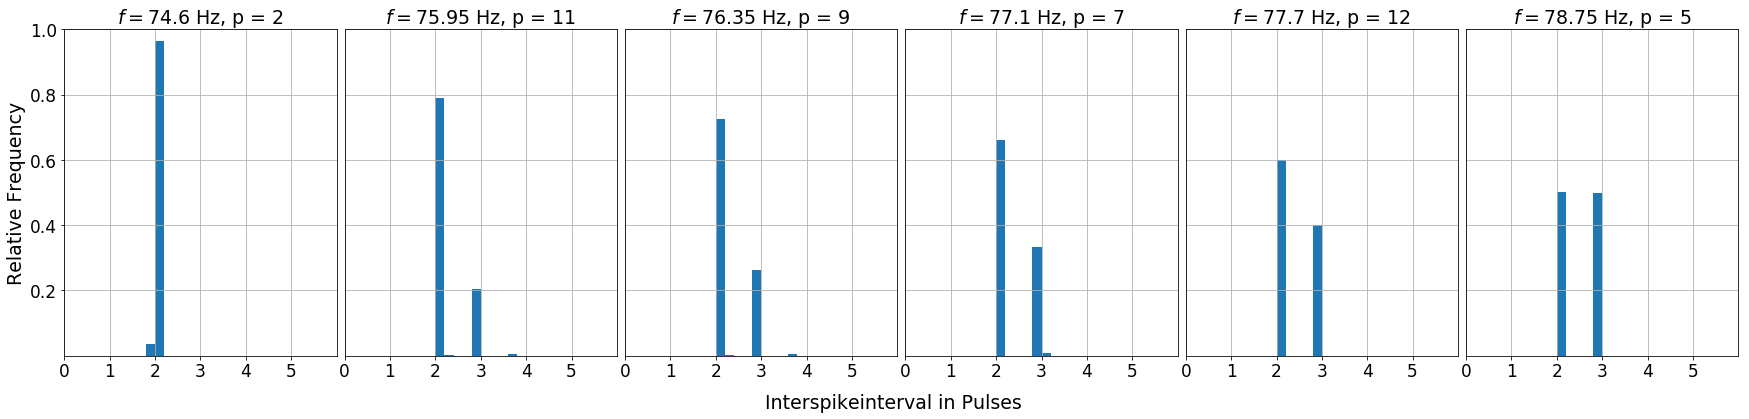

In [4]:
#f_hists = np.arange(66, 84, 1) #or
transition = True
small21 = False
particular = False
#TRANSITION FROM 2 TO 3
if transition:
    f_hists = ([74.6, 75.95, 76.35, 77.1, 77.7, 78.75]) #TRANSITION
if small21:
    f_hists = ([74.30, 74.35, 74.4, 74.45, 74.5, 74.55]) #SMALL 2:1
if particular:
    f_hists = ([70.25, 73.15, 99.0, 99.4, 101.0, 107.5]) #SPECIAL PERIODS
    f_hists = ([99.01, 99.3, 99.4, 100.22, 101.0, 107.5]) #SPECIAL PERIODS
    
#f_hists = ([70.26, 73.29, 73.47, 99.30])
#f_hists = ([95.69])
#f_hists = ([74.6])
#perioddoubling: 

#CHAOS: 99
#3 PERIODS: 70.2 
# Transition away from a locking?

#TO DO: COMPUTE R FOR N PERIODS?
#f_hists = ([82.1, 82.2, 100.6, 101.0])


textsize = 19 #change here

f = plt.figure(figsize = (30, 6))
#f = plt.figure(figsize = (13,5))
#f = plt.figure(figsize = (6,5))

for k in range(0, len(f_hists)):
    f.add_subplot(1, 6, k+1)
    #f.add_subplot(1, 3, k+1)
    rel_isi, bins, rate, vecstr = spikeresponse_rec15_hist(kepler, 5.0, 8.0, f_hists[k])
    weights = np.ones_like(rel_isi)/float(len(rel_isi))
    plt.hist(rel_isi, bins, weights = weights)
    plt.axis((0, 6, 0.0, 1.0))
    #plt.xlabel('Interspikeinterval in Pulses', fontsize = textsize)
    if k == 0:
        plt.ylabel('Relative Frequency', fontsize = textsize)#Frequency?
        plt.yticks(np.arange(0.2, 1.2, .2), fontsize = 17)
    else:
        plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False)
    if k == 2:
    #if k == 1:
        #plt.text(6.1-3.125-5+1.5, -.125/2, 'Interspikeinterval in Pulses', fontsize = textsize)
        plt.text(6.1-3.125+.11, -.16, 'Interspikeinterval in Pulses', fontsize = textsize) #for transition
        #plt.text(6.1-2.25, 1.25, 'Period Transition', fontsize = textsize + 3)
    plt.xticks(np.arange(0, 6, 1), fontsize = 17)
    #plt.title(r'$f = {}$, p = '.format(f_hists[k]), fontsize = textsize)
    
    #manual
    if transition:
        if k == 0:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)  
        if k == 1:
            plt.title(r'$f = {}$ Hz, p = 11'.format(f_hists[k]), fontsize = textsize)  
        if k == 2:
            plt.title(r'$f = {}$ Hz, p = 9'.format(f_hists[k]), fontsize = textsize)  
        if k == 3:
            plt.title(r'$f = {}$ Hz, p = 7'.format(f_hists[k]), fontsize = textsize)  
        if k == 4:
            plt.title(r'$f = {}$ Hz, p = 12'.format(f_hists[k]), fontsize = textsize)
        if k == 5:
            plt.title(r'$f = {}$ Hz, p = 5'.format(f_hists[k]), fontsize = textsize)
    if small21:
        if k == 0:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)  
        if k == 1:
            plt.title(r'$f = {}$ Hz, p = n.a.'.format(f_hists[k]), fontsize = textsize)  
        if k == 2:
            plt.title(r'$f = {}$ Hz, p = 36'.format(f_hists[k]), fontsize = textsize)  
        if k == 3:
            plt.title(r'$f = {}$ Hz, p = n.a.'.format(f_hists[k]), fontsize = textsize)  
        if k == 4:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)
        if k == 5:
            plt.title(r'$f = {}$ Hz, p = n.a.'.format(f_hists[k]), fontsize = textsize)
    if particular:
        if k == 0:
            plt.title(r'$f = {}$ Hz, p = 5'.format(f_hists[k]), fontsize = textsize) 
        if k == 1:
            plt.title(r'$f = {}$ Hz, p = 8'.format(f_hists[k]), fontsize = textsize)  
        if k == 2:
            plt.title(r'$f = {}$ Hz, p = 4.'.format(f_hists[k]), fontsize = textsize)
        if k == 3:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)  
        if k == 4:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)
        if k == 5:
            plt.title(r'$f = {}$ Hz, p = 2'.format(f_hists[k]), fontsize = textsize)
    
    plt.grid()
    #plt.title(r'$f = {}$, $k = {:.2f}$, $r = {:.2f}$'.format(f_hists[k], rate/f_hists[k], vecstr), fontsize = textsize)
    plt.subplots_adjust(wspace = .03)
    #plt.subplots_adjust(wspace = .5)
if transition:
    plt.savefig('BA_isihist_transition_newtime3.pdf')
if small21:
    plt.savefig('BA_isihist_small21_newtime3.pdf')
if particular:
    plt.savefig('BA_isihist_pdoubling_newtime3.pdf')
#periods are the weighted sum of the histogramm bins

66.15: 1 (1)
70.25: 1,2 (3)
73.15: 1,2,3 (6)
74.15-
74.3: 2 (2)
74.5: 2
74.6-
74.7: 2
74.8: 2
75.45: 2,2,2,2,2,3 (13)
75.95: 2,2,2,2,3   (11)
76.35
-76.45: 2,2,2,3 (9)
77.05: 2,2,3        (7)
77.15-
77.2: 2,2,3   (7)
77.7: 2,2,2,3,3    (12)
78.45-79.0: 2,3    (5)
79.8-79.9: 2,2,3,3,3(13)
80.35-81.2: 2,3,3 (8)
81.55-81.65: 2,3,3,3,3(14)
82.1: 3,3 (6)
82.2
-94.9: 3 (3)
95.95
-96.25 2,2,3 (7)
96.85: 2,2,2,2,3 (11)
99.4
-100.95 2,2 (4)
101.0
-108.0: 2 (2)




[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.ndarray'>
77.7


"\nplt.text(66.20, 1.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 2.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 3.0, r'$(2)_0 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)\nplt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)\n"

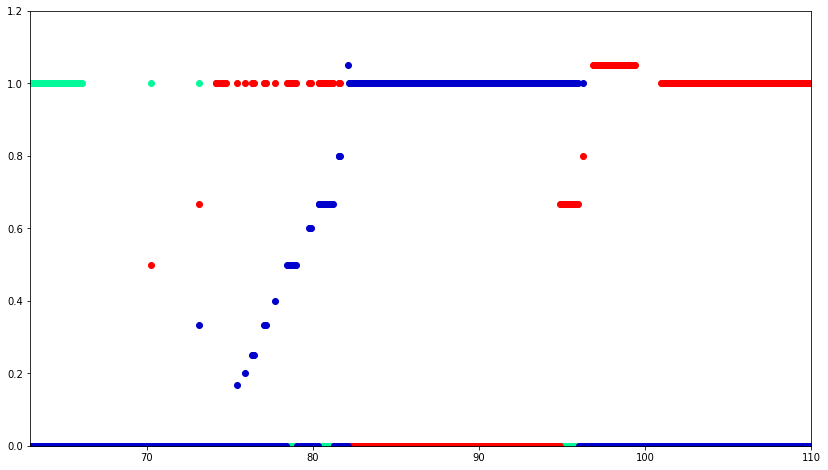

In [98]:
frange = np.arange(63, 110+.05, .05)
ones = np.zeros(len(frange))
twos = np.zeros(len(frange))
threes = np.zeros(len(frange))
f1 = np.where(frange > 66.15)[0][0]
fcrits = (66.15, 70.25, 73.15, 74.15, 74.3, 74.5, 74.6, 74.7,
          74.8, 75.45, 75.95, 76.35, 76.45, 77.05, 77.15, 77.2,
          77.7, 78.45, 79.0, 79.8, 79.9, 80.35, 81.2, 81.55,
          81.65, 82.1, 82.2, 94.9, 95.95, 96.25, 96.85, 99.4, 100.95, 101.0)
#ones1[:np.where(frange == 66.15)]
#plt.plot()
fi = np.zeros(len(fcrits))
print(fi)
for counter, walk in enumerate(fcrits, 0):
    fi[counter] = np.where(frange > walk)[0][0]
fi -= 1
fi = fi.astype(int)

print(type(fi))
#print(fcindices)

ones[:fi[0]] = 1
ones[fi[1]] = 1
twos[fi[1]] = 1/2

ones[fi[2]] = 1
twos[fi[2]] = 2/3
threes[fi[2]] = 1/3

twos[fi[3]:fi[4]+1] = 1
twos[fi[5]] = 1
twos[fi[6]:fi[7]+1] = 1
twos[fi[8]] = 1

twos[fi[9]] = 1
threes[fi[9]] = 1/6

twos[fi[10]] = 1
threes[fi[10]] = 1/5

twos[fi[11]:fi[12]+1] = 1
threes[fi[11]:fi[12]+1] = 1/4

twos[fi[13]] = 1
threes[fi[13]] = 1/3

twos[fi[14]:fi[15]+1] = 1
threes[fi[14]:fi[15]+1] = 1/3

twos[fi[16]] = 1
threes[fi[16]] = 2/5

twos[fi[17]:fi[18]+1] = 1
threes[fi[17]:fi[18]+1] = 1/2

twos[fi[19]:fi[20]+1] = 1
threes[fi[19]:fi[20]+1] = 3/5

twos[fi[21]:fi[22]+1] = 1
threes[fi[21]:fi[22]+1] = 2/3
print(frange[fi[16]])
twos[fi[23]:fi[24]+1] = 1
threes[fi[23]:fi[24]+1] = 4/5


threes[fi[25]] = 1.05

threes[fi[26]:fi[27]+1] = 1 #3:1 LOCKING


threes[fi[27]:fi[28]+1] = 1
twos[fi[27]:fi[28]+1] = 2/3

threes[fi[29]] = 1
twos[fi[29]] = 4/5

twos[fi[30]:fi[31]+1] = 1.05

#print(frange[fi[32]])

twos[fi[32]:-1] = 1
twos[-1] = 1
#print(twos[-1])


#print(len(fi))



#print(ones)
#print(twos)
plt.figure(figsize = (14,8))
plt.scatter(frange, ones, color = 'mediumspringgreen')
plt.scatter(frange, twos, color = 'red')
plt.scatter(frange, threes, color = 'mediumblue')

plt.axis((min(frange), max(frange),0,1.2))
'''
plt.text(66.20, 1.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 2.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 3.0, r'$(2)_0 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)
plt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)
'''

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ 0.01        0.01        0.01        0.33333333  0.01        0.01        0.01
  0.01        0.01        0.01        0.16666667  0.2         0.25        0.25
  0.33333333  0.33333333  0.33333333  0.4         0.5         0.5         0.6
  0.6         0.66666667  0.66666667  0.8         0.8         1.1         1.
  1.          0.33333333  0.33333333  0.2         0.01        0.01        0.01
  0.01      ]
[  63.     66.15   70.25   73.15   74.15   74.3    74.5    74.6    74.7
   74.8    75.45   75.95   76.35   76.45   77.05   77.15   77.2    77.7
   78.45   79.     79.8    79.9    80.35   81.2    81.55   81.65   82.1
   82.2    94.9    95.95   96.25   96.85   99.4   100.95  101.    108.  ]
36
36
36
36


"\nplt.text(66.20, 1.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 2.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 3.0, r'$(2)_0 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)\nplt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)\n"

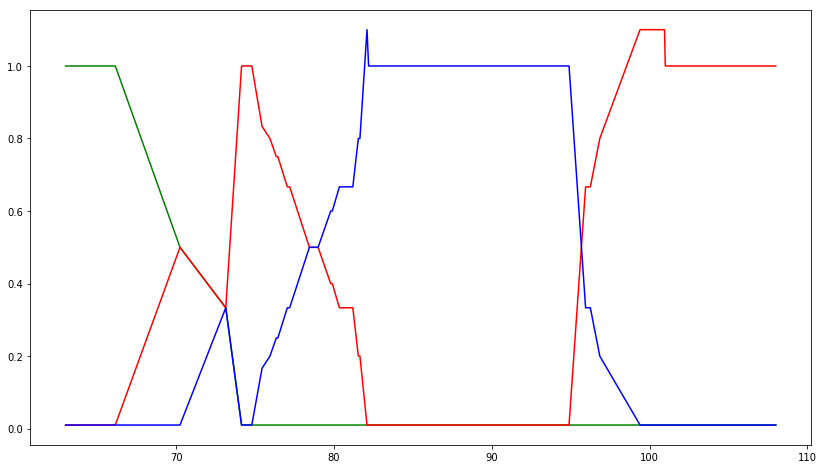

In [125]:
frange = np.arange(63, 110+.05, .05)
ones = np.zeros(len(frange))
twos = np.zeros(len(frange))
threes = np.zeros(len(frange))
f1 = np.where(frange > 66.15)[0][0]
fcrits = (66.15, 70.25, 73.15, 74.15, 74.3, 74.5, 74.6, 74.7,
          74.8, 75.45, 75.95, 76.35, 76.45, 77.05, 77.15, 77.2,
          77.7, 78.45, 79.0, 79.8, 79.9, 80.35, 81.2, 81.55,
          81.65, 82.1, 82.2, 94.9, 95.95, 96.25, 96.85, 99.4, 100.95, 101.0)
#ones1[:np.where(frange == 66.15)]
#plt.plot()
fi = np.zeros(len(fcrits))
print(fi)
for counter, walk in enumerate(fcrits, 0):
    fi[counter] = np.where(frange > walk)[0][0]
fi -= 1
fi = fi.astype(int)

print(type(fi))
#print(fcindices)

ones[0] = 1
ones[fi[0]] = 1
twos[0] = .01
twos[fi[0]] = .01
threes[0] = .01
threes[fi[0]] = .01

ones[fi[1]] = 1/2
twos[fi[1]] = 1/2
threes[fi[1]] = .01

ones[fi[2]] = 1/3
twos[fi[2]] = 1/3
threes[fi[2]] = 1/3

twos[fi[3]] = 1
twos[fi[4]+1] = 1
threes[fi[3]] = .01
threes[fi[4]+1] = .01
ones[fi[3]] = .01
ones[fi[4]+1] = .01


twos[fi[5]] = 1
ones[fi[5]] = .01
threes[fi[5]] = .01


twos[fi[6]] = 1
threes[fi[6]] = .01
ones[fi[6]] = .01
twos[fi[7]+1] = 1
ones[fi[7]+1] = .01
threes[fi[7]+1] = .01


twos[fi[8]] = 1
ones[fi[8]] = .01
threes[fi[8]] = .01



twos[fi[9]] = 5/6
threes[fi[9]] = 1/6
ones[fi[9]] = .01

twos[fi[10]] = 4/5
threes[fi[10]] = 1/5
ones[fi[10]] = .01

twos[fi[11]] = 3/4
threes[fi[11]] = 1/4
ones[fi[11]] = .01
twos[fi[12]+1] = 3/4
threes[fi[12]+1] = 1/4
ones[fi[12]+1] = .01

twos[fi[13]] = 2/3
threes[fi[13]] = 1/3
ones[fi[13]] = .01

twos[fi[14]] = 2/3
ones[fi[14]] = .01
threes[fi[14]] = 1/3
twos[fi[15]+1] = 2/3
threes[fi[15]+1] = 1/3
ones[fi[15]+1] = .01

twos[fi[16]] = 3/5
threes[fi[16]] = 2/5
ones[fi[16]] = .01

twos[fi[17]] = 1/2
ones[fi[17]] = .01
threes[fi[17]] = 1/2
twos[fi[18]+1] = 1/2
threes[fi[18]+1] = 1/2
ones[fi[18]+1] = .01

ones[fi[19]] = .01
twos[fi[19]] = 2/5
threes[fi[19]] = 3/5
ones[fi[20]+1] = .01
twos[fi[20]+1] = 2/5
threes[fi[20]+1] = 3/5

twos[fi[21]] = 1/3
threes[fi[21]] = 2/3
ones[fi[21]] = .01
twos[fi[22]+1] = 1/3
threes[fi[22]+1] = 2/3
ones[fi[22]+1] = .01

twos[fi[23]] = 1/5
ones[fi[23]] = .01
threes[fi[23]] = 4/5
twos[fi[24]+1] = 1/5
threes[fi[24]+1] = 4/5
ones[fi[24]+1] = .01

ones[fi[25]] = .01
twos[fi[25]] = .01
threes[fi[25]] = 1.1


twos[fi[26]] = .01
ones[fi[26]] = .01
twos[fi[27]] = .01 #3:1 LOCKING
ones[fi[27]] = .01 #3:1 LOCKING

threes[fi[26]] = 1
threes[fi[27]] = 1 #3:1 LOCKING


ones[fi[27]+1] = .01
threes[fi[27]+1] = 1/3
twos[fi[27]+1] = 2/3
ones[fi[28]+1] = .01
threes[fi[28]+1] = 1/3
twos[fi[28]+1] = 2/3

ones[fi[29]] = .01
threes[fi[29]] = 1/5
twos[fi[29]] = 4/5


ones[fi[30]] = .01
twos[fi[30]] = 1.1
threes[fi[30]] = .01
twos[fi[31]+1] = 1.1
ones[fi[31]+1] = 0.01
threes[fi[31]+1] = 0.01

#print(frange[fi[32]])

twos
twos[fi[32]] = 1
ones[fi[32]] = .01
threes[fi[32]] = .01
twos[-1] = 1
ones[-1] = .01
threes[-1] = .01


#print(twos[-1])


#print(len(fi))



#print(ones)
#print(twos)
plt.figure(figsize = (14,8))

print(type(frangenew))
frangenew = frange[fi]
frangenew = np.concatenate((np.array([63.0]), frangenew))
frangenew = np.concatenate((frangenew, np.array([108.0])))
threesnew = threes[threes>0.0]
twosnew = twos[twos>0.0]
onesnew = ones[ones>0.0]
print(threesnew)

print(frangenew)


print(len(frangenew))
print(len(onesnew))
print(len(twosnew))
print(len(threesnew))
#plt.scatter(frangenew, onesnew, color = 'mediumspringgreen')
#plt.scatter(frange, twos, color = 'red')
#plt.scatter(frange, threes, color = 'mediumblue')

#plt.axis((min(frange), max(frange),0,1.2))
plt.plot(frangenew, onesnew, color = 'green')
plt.plot(frangenew, twosnew, color = 'red')
plt.plot(frangenew, threesnew, color = 'blue')





'''
plt.text(66.20, 1.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 2.0, r'$(2)_0 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 3.0, r'$(2)_0 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)
plt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)
plt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)
plt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)
plt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)
'''

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ 0.001       0.001       0.001       0.33333333  0.001       0.001       0.001
  0.001       0.001       0.001       0.16666667  0.2         0.25        0.25
  0.33333333  0.33333333  0.33333333  0.4         0.5         0.5         0.6
  0.6         0.66666667  0.66666667  0.8         0.8         1.          1.
  1.          0.33333333  0.33333333  0.2         0.001       0.001       0.001
  0.001     ]
[  63.     66.15   70.25   73.15   74.15   74.3    74.5    74.6    74.7
   74.8    75.45   75.95   76.35   76.45   77.05   77.15   77.2    77.7
   78.45   79.     79.8    79.9    80.35   81.2    81.55   81.65   82.1
   82.2    94.9    95.95   96.25   96.85   99.4   100.95  101.    108.  ]
36
36
36
36
74.15


"\n\nplt.text(66.20, 4.0, r'$(2)_2 (3)_0$', color = 'red', fontsize = 13)\nplt.text(66.20, 5.0, r'$(2)_1 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 6.0, r'$(2)_0 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 7.0, r'$(2)_2 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 8.0, r'$(2)_1 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 9.0, r'$(2)_3 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 11.0, r'$(2)_4 (3)_1$', color = 'red', fontsize = 13)\nplt.text(66.20, 12.0, r'$(2)_3 (3)_2$', color = 'red', fontsize = 13)\nplt.text(66.20, 13.0, r'$(2)_2 (3)_3$', color = 'red', fontsize = 13)\nplt.text(66.20, 14.0, r'$(2)_1 (3)_4$', color = 'red', fontsize = 13)\n"

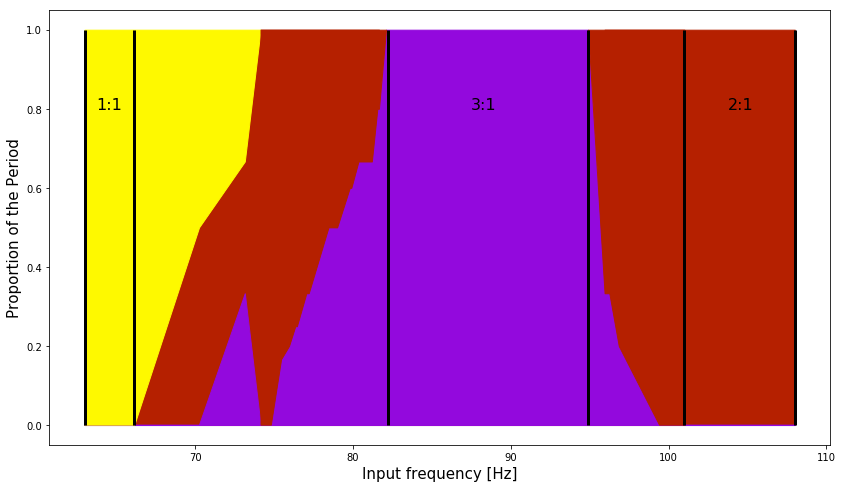

In [27]:
cmap = plt.get_cmap('gnuplot')

frange = np.arange(63, 110+.05, .05)
ones = np.zeros(len(frange))
twos = np.zeros(len(frange))
threes = np.zeros(len(frange))
f1 = np.where(frange > 66.15)[0][0]
fcrits = (66.15, 70.25, 73.15, 74.15, 74.3, 74.5, 74.6, 74.7,
          74.8, 75.45, 75.95, 76.35, 76.45, 77.05, 77.15, 77.2,
          77.7, 78.45, 79.0, 79.8, 79.9, 80.35, 81.2, 81.55,
          81.65, 82.1, 82.2, 94.9, 95.95, 96.25, 96.85, 99.4, 100.95, 101.0)
#ones1[:np.where(frange == 66.15)]
#plt.plot()
fi = np.zeros(len(fcrits))
print(fi)
for counter, walk in enumerate(fcrits, 0):
    fi[counter] = np.where(frange > walk)[0][0]
fi -= 1
fi = fi.astype(int)

print(type(fi))
#print(fcindices)

ones[0] = 1
ones[fi[0]] = 1
twos[0] = .001
twos[fi[0]] = .001
threes[0] = .001
threes[fi[0]] = .001

ones[fi[1]] = 1
twos[fi[1]] = 1/2
threes[fi[1]] = .001

ones[fi[2]] = 1
twos[fi[2]] = 2/3
threes[fi[2]] = 1/3

twos[fi[3]] = 1
twos[fi[4]+1] = 1
threes[fi[3]] = .001
threes[fi[4]+1] = .001
ones[fi[3]] = .001
ones[fi[4]+1] = .001


twos[fi[5]] = 1
ones[fi[5]] = .001
threes[fi[5]] = .001


twos[fi[6]] = 1
threes[fi[6]] = .001
ones[fi[6]] = .001
twos[fi[7]+1] = 1
ones[fi[7]+1] = .001
threes[fi[7]+1] = .001


twos[fi[8]] = 1
ones[fi[8]] = .001
threes[fi[8]] = .001



twos[fi[9]] = 1
threes[fi[9]] = 1/6
ones[fi[9]] = .001

twos[fi[10]] = 1
threes[fi[10]] = 1/5
ones[fi[10]] = .001

twos[fi[11]] = 1
threes[fi[11]] = 1/4
ones[fi[11]] = .001
twos[fi[12]+1] = 1
threes[fi[12]+1] = 1/4
ones[fi[12]+1] = .001

twos[fi[13]] = 1
threes[fi[13]] = 1/3
ones[fi[13]] = .001

twos[fi[14]] = 1
ones[fi[14]] = .001
threes[fi[14]] = 1/3
twos[fi[15]+1] = 1
threes[fi[15]+1] = 1/3
ones[fi[15]+1] = .001

twos[fi[16]] = 1
threes[fi[16]] = 2/5
ones[fi[16]] = .001

twos[fi[17]] = 1
ones[fi[17]] = .001
threes[fi[17]] = 1/2
twos[fi[18]+1] = 1
threes[fi[18]+1] = 1/2
ones[fi[18]+1] = .001

ones[fi[19]] = .001
twos[fi[19]] = 1
threes[fi[19]] = 3/5
ones[fi[20]+1] = .001
twos[fi[20]+1] = 1
threes[fi[20]+1] = 3/5

twos[fi[21]] = 1
threes[fi[21]] = 2/3
ones[fi[21]] = .001
twos[fi[22]+1] = 1
threes[fi[22]+1] = 2/3
ones[fi[22]+1] = .001

twos[fi[23]] = 1
ones[fi[23]] = .001
threes[fi[23]] = 4/5
twos[fi[24]+1] = 1
threes[fi[24]+1] = 4/5
ones[fi[24]+1] = .001

ones[fi[25]] = .001
twos[fi[25]] = .001
threes[fi[25]] = 1


twos[fi[26]] = .001
ones[fi[26]] = .001
twos[fi[27]] = .001 #3:1 LOCKING
ones[fi[27]] = .001 #3:1 LOCKING

threes[fi[26]] = 1
threes[fi[27]] = 1 #3:1 LOCKING
#LOL

ones[fi[27]+1] = .001
threes[fi[27]+1] = 1/3
twos[fi[27]+1] = 1
ones[fi[28]+1] = .001
threes[fi[28]+1] = 1/3
twos[fi[28]+1] = 1

ones[fi[29]] = .001
threes[fi[29]] = 1/5
twos[fi[29]] = 1


ones[fi[30]] = .001
twos[fi[30]] = 1
threes[fi[30]] = .001
twos[fi[31]+1] = 1
ones[fi[31]+1] = .001
threes[fi[31]+1] = .001

#print(frange[fi[32]])

twos
twos[fi[32]] = 1
ones[fi[32]] = .001
threes[fi[32]] = .001
twos[-1] = 1
ones[-1] = .001
threes[-1] = .001


#print(twos[-1])


#print(len(fi))



#print(ones)
#print(twos)
plt.figure(figsize = (14,8))


frangenew = frange[fi]
print(type(frangenew))
frangenew = np.concatenate((np.array([63.0]), frangenew))
frangenew = np.concatenate((frangenew, np.array([108.0])))
threesnew = threes[threes>0.0]
twosnew = twos[twos>0.0]
onesnew = ones[ones>0.0]
print(threesnew)

print(frangenew)


print(len(frangenew))
print(len(onesnew))
print(len(twosnew))
print(len(threesnew))
#plt.scatter(frangenew, onesnew, color = 'mediumspringgreen')
#plt.scatter(frange, twos, color = 'red')
#plt.scatter(frange, threes, color = 'mediumblue')

#plt.axis((min(frange), max(frange),0,1.2))
#plt.plot(frangenew, onesnew, color = 'green')
#plt.plot(frangenew, twosnew, color = 'red')
#plt.plot(frangenew, threesnew, color = 'blue')



#plt.fill_between(frangenew, 0, onesnew, color = 'green')
#plt.fill_between(frangenew[0:27], 0, twosnew[0:27], color = 'red')

plt.fill_between(frangenew, 0, twosnew, color = cmap(1/2))
plt.fill_between(frangenew, 0, threesnew, color = cmap(1/3))
#plt.fill_between(frangenew[27:-1], 0, twosnew[27:-1], color = 'red')
print(frange[fi[3]])
plt.fill_between(frangenew[0:5], twosnew[0:5], 1, color = cmap(.99))
plt.fill_between(frangenew[4:27], threesnew[4:27], 1, color = cmap(1/2))
plt.fill_between(frangenew[28:-1], threesnew[28:-1], 1, color = cmap(1/2))

#plt.text(64.575, .9, r'$(1)$', color = 'black', fontsize = 13)
#plt.text(87.25, .9, r'$(2)$', color = 'black', fontsize = 13)
#plt.text(101.5, .9, r'$(3)$', color = 'black', fontsize = 13)

plt.text(63.75, .8, r'1:1', fontsize = 16) #standard is 10
plt.text(87.45, .8, r'3:1', fontsize = 16)
plt.text(103.75, .8, r'2:1', fontsize = 16)

plt.xlabel('Input frequency [Hz]', fontsize = 15);
plt.ylabel('Proportion of the Period', fontsize = 15);

plt.vlines(x=63.0, ymin =0, ymax = 1, color = 'black', linewidth = 3)
plt.vlines(x=66.15, ymin =0, ymax = 1, color = 'black', linewidth = 3)
plt.vlines(x=82.2, ymin =0, ymax = 1, color = 'black', linewidth = 3)
plt.vlines(x=94.9, ymin =0, ymax = 1, color = 'black', linewidth = 3)
plt.vlines(x=101.0, ymin =0, ymax = 1, color = 'black', linewidth = 3)
plt.vlines(x=108.0, ymin =0, ymax = 1, color = 'black', linewidth = 3)



In [34]:
np.arange(.5, 6.5, 1) #??? OLD

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5])